<a href="https://colab.research.google.com/github/prakhar-luke/pytorch_practice/blob/main/01_pytorch_workflow_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# pyTorch version
torch.__version__

'2.0.1+cu118'

# what we're covering
-    1: "data (prepare and load)"
-    2: "build model"
-    3: "fitting the model to data - (training)"
-    4: "making predictions and evaluating a model (inference)"
-    5: "saving and loading a model"
-    6: "putting it all together"

# 1. Data (prepare and load)

In [ ]:
# use a liner regression formula to make a straight line with known parameter

# Create Known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

## Split data into train & test sets

In [ ]:
# Create Train and Test sets
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

40 40 10 10


In [ ]:
# Visualize it
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plot training data, test data and compare predictions
  """
  plt.figure(figsize=(10,7))

  # plot train data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

  # plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')

  # plot prediction if they exist
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  plt.legend(prop={'size':14});

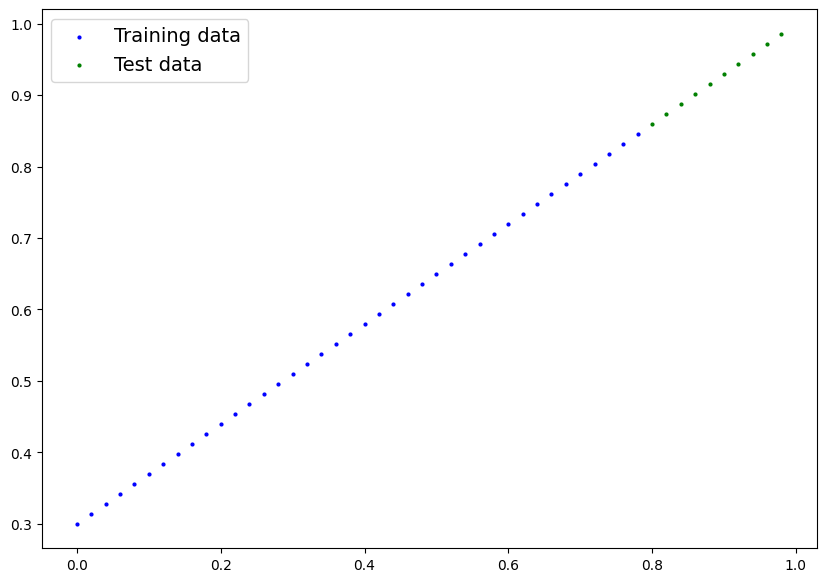

In [ ]:
plot_predictions()

# 2. Build Model

In [ ]:
# Create linear regressin model class
class LinearRegressionModel(nn.Module): # nn.Module contain all the building blocks for NN
  def __init__(self):
    super().__init__()
    # initialize model paramater
    # to be used in various computations
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True, # means torch will track gradient of this specific paramater for use with torch.autograd
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad = True,
                                         dtype=torch.float))

    # Fotward method to define the computation in the model
    # any subclass of nn.Module needs to override forward()
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
      return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

Checking the contents of a pytorch model

In [ ]:
# set random seed
torch.manual_seed(42)

# create an instance of model
model_0 = LinearRegressionModel()

# Check the nn.Parameter()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### make prediction with model using `torch.inference_mode()`
when passed data to model it run `forward()` function

In [ ]:
# Make predictions with model using `torch.inference_mode()`
# it turns off gradient tracking cause right now we're doing inference not
# training so we dont' need to keep track of gradient for backpropigation
# so for large dataset during inference mode it saves memory hence boosting performance
with torch.inference_mode():
    y_preds = model_0(X_test)

In [ ]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
y_preds2 = model_0(X_test)
y_preds2

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

`torch.inference_mode()` is a new functionality in PyTorch as of v1.912. It is analogous to `torch.no_grad()`, but it provides better performance by disabling view tracking and version counter bumps. This is particularly useful when you are certain your operations will have no interactions with autograd, such as during model training.

When you use `model(X_train)`, PyTorch tracks all the operations performed on the tensors involved in the forward pass of the model. This is necessary for backpropagation, which computes gradients for model parameters for training. However, during inference (i.e., model evaluation), you don’t need gradients or backpropagation.

In such cases, using `torch.inference_mode()` can give you a performance boost. It’s preferable to `torch.no_grad()` in all situations where inference mode does not throw a runtime error. So, if you’re just evaluating your model and not training it, using `torch.inference_mode()` with `model(X_train)` can be beneficial.

However, please note that `model.eval()` and `torch.no_grad()` or `torch.inference_mode()` serve different purposes. While the latter two disable gradient computation, model.eval() sets the model to evaluation mode, affecting layers like dropout and batch normalization. So, typically, you’d use them together during inference:

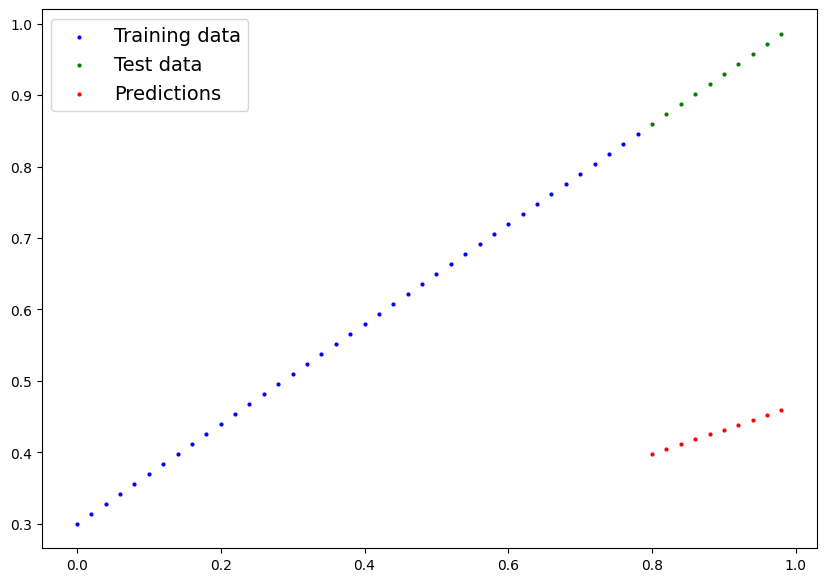

In [ ]:
plot_predictions(predictions=y_preds)

# 3. Train Model

In [ ]:
# Creating loss function
loss_fn = nn.L1Loss()  # MAE (mean absolute error)

# Creating optimizer *stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), lr= 0.01)

## Creating optimization loop in PyTorch

### PyTorch Trainig loop
1. Forward pass
2. Calculate loss
3. Zero Gradients optimization
4. BackPropagation on loss (**back propagation**)
5. Update Optimizer (**gradient descent**)

### PyTorch Testing loop
1. Forward pass
2. Calculate loss
3. Calculate evaluation metrics

In [ ]:
torch.manual_seed(42)

# epoch is one loop through the data
epochs = 200

# create enpty list to track values
epoch_count = []
train_loss_values =[]
test_loss_values =[]

for epoch in range(epochs):
  ### TRAINING LOOP

  # set model to training mode
  model_0.train() # train mode in pytorch sets all parameters the require gradienst to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate Loss
  loss = loss_fn(y_pred, y_train)

  # 3. optimize Zero Gradient
  optimizer.zero_grad()

  # 4. Back-Propagation
  loss.backward()

  # 5. Update Optimizer
  optimizer.step()

  ### TESTING LOOP

  # put model in evaluation mode
  model_0.eval() # turns off gradient tracking and other settings (dropout, batchnorm etc)

  with torch.inference_mode():
    # 1. Forward Pass on test data
    test_pred = model_0(X_test)  # come in torch.float datatype

    # 2. calc loss on test data
    test_loss = loss_fn(test_pred, y_test.type(torch.float))  # since test_pred is in torch.float so y_test needs to be converted

  # Print out what's happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f"EPOCH : {epoch} | Loss : {loss} | Test Loss : {test_loss}")
    print(model_0.state_dict())


EPOCH : 0 | Loss : 0.31288138031959534 | Test Loss : 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
EPOCH : 10 | Loss : 0.1976713240146637 | Test Loss : 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
EPOCH : 20 | Loss : 0.08908725529909134 | Test Loss : 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
EPOCH : 30 | Loss : 0.053148526698350906 | Test Loss : 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
EPOCH : 40 | Loss : 0.04543796554207802 | Test Loss : 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
EPOCH : 50 | Loss : 0.04167863354086876 | Test Loss : 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
EPOCH : 60 | Loss : 0.03818932920694351 | Test Loss : 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('

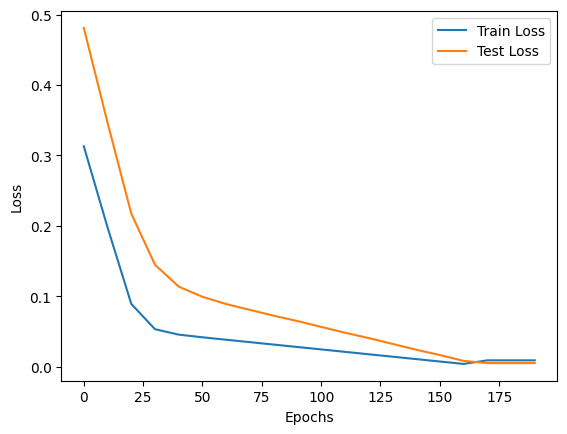

In [ ]:
from prompt_toolkit.shortcuts.progress_bar.formatters import Label
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

# 4. Making Prediction (inference)


In [ ]:
# set model to evaluation mode
model_0.eval()

# setup inference mode context manager
with torch.inference_mode():
  y_pred = model_0(X_test)
y_pred

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

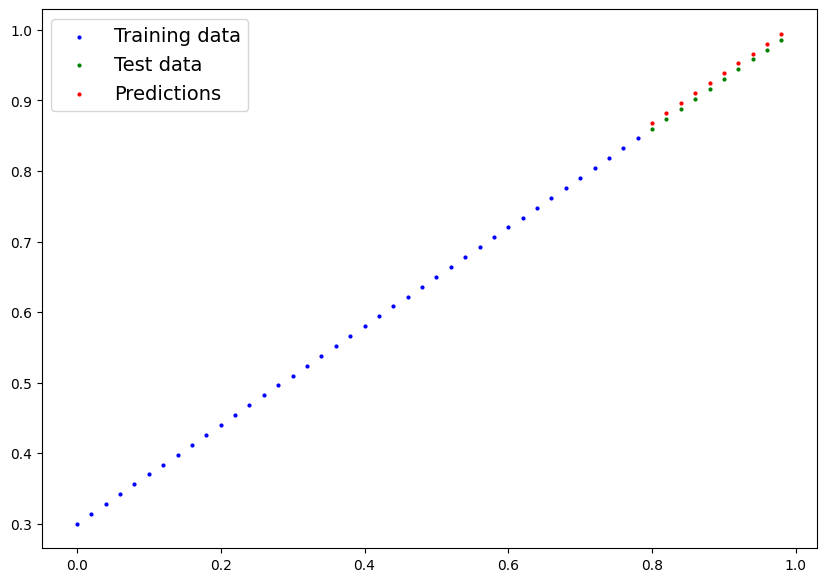

In [ ]:
plot_predictions(predictions=y_pred)

# 5. Saving and Loading torch model

1. `torch.save()` - save PyTorch object in Python's pickle format
2. `torch.load()` - load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary

## Save PyTorch Model `state_dict()`

In [ ]:
from pathlib import Path

# 1. create a model dir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model state_dict
print(f'SAVING MODEL TO {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

SAVING MODEL TO models/01_pytorch_workflow_model_0.pth


## Load saved PyTorch Model `load_state_dict()`

In [ ]:
# to load in a saved state_dict() we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0
# (this will update the new instance with updated paramaters)
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
# Make prediction with loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_pred = loaded_model_0(X_test)

loaded_model_pred

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Make some models preds
model_0.eval()
with torch.inference_mode():
  y_preds_test = model_0(X_test)
y_preds_test

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
y_preds_test == loaded_model_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting it all together

In [1]:
# Import PyTorch & matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'2.0.1+cu118'

In [12]:
# setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using device : {device}')

using device : cuda


## 1. Data

In [3]:
# Create weights and biase
weight = 0.7
biase = 0.3

# create range values
start = 0
end = 1
step = 0.02

# create X, y (features , lables)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + biase
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
# plot function
def plot_pred(train_data = X_train,
              train_labels = y_train,
              test_data = X_test,
              test_labels = y_test,
              predictions = None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c='b', s=5, label="Training data")
  plt.scatter(test_data, test_labels, c='g', s=5, label="Testing data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=5, label='Prediction')
  plt.legend(prop={'size':14});

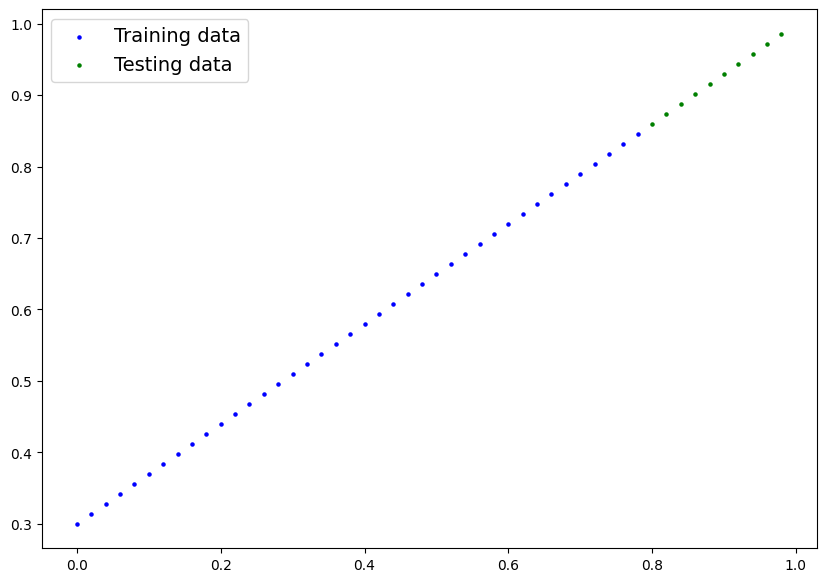

In [6]:
plot_pred(X_train, y_train, X_test, y_test)

## 2. Building PyTorch LinearModel

In [17]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # nn.Linear() for createing the model parameters
    self.linear_layer = nn.Linear(in_features=1, out_features=1)
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [18]:
# checking model device
next(model_1.parameters()).device

device(type='cpu')

In [19]:
# set model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## 3. Training

* loss function
* optimizer
* training loop
* testing loop

In [20]:
# create loss fucntion
loss_fn = nn.L1Loss()

# create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [22]:
# Train loop
torch.manual_seed(42)

# set epoch
epochs = 500

# put data on the available device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ## TRAINING
  # set model for train mode
  model_1.train()
  # 1. forward pass
  y_pred = model_1(X_train)
  # 2. calc loss
  loss = loss_fn(y_pred, y_train)
  # 3. set optimizer grad zero
  optimizer.zero_grad()
  # 4. back prop on loss
  loss.backward()
  # 5. optimizer step
  optimizer.step()

  ## TESTING
  # set model for testing mode
  model_1.eval()
  with torch.inference_mode():
    # 1. forward
    test_pred = model_1(X_test)
    # 2. calc loss
    test_loss = loss_fn(test_pred, y_test)

  # display whats happening
  if epoch % 100 == 0:
    print(f'EPOCH : {epoch} | TRAIN LOSS : {loss} | TEST LOSS : {test_loss}')


EPOCH : 0 | TRAIN LOSS : 0.0012645035749301314 | TEST LOSS : 0.013801801018416882
EPOCH : 100 | TRAIN LOSS : 0.0012645035749301314 | TEST LOSS : 0.013801801018416882
EPOCH : 200 | TRAIN LOSS : 0.0012645035749301314 | TEST LOSS : 0.013801801018416882
EPOCH : 300 | TRAIN LOSS : 0.0012645035749301314 | TEST LOSS : 0.013801801018416882
EPOCH : 400 | TRAIN LOSS : 0.0012645035749301314 | TEST LOSS : 0.013801801018416882


In [24]:
from pprint import pprint
print("learned by MODEL : ")
pprint(model_1.state_dict())
print('\nOriginal values : ')
pprint(f'weights : {weight}, biase : {biase}')

learned by MODEL : 
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

Original values : 
'weights : 0.7, biase : 0.3'


## 4. Making predictions

In [25]:
# turn model into evaluation mode
model_1.eval()

# make preds on test set
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

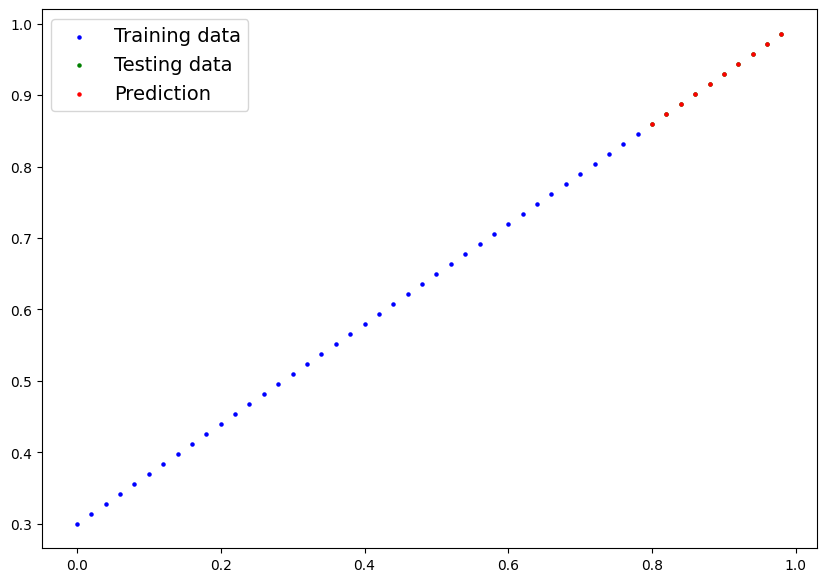

In [26]:
# plot_pred() with y_preds won't work because data is not in CPU
# put data on cpu then plot it
plot_pred(predictions=y_preds.cpu())

## 5. Saving and Loading

In [27]:
from pathlib import Path

# 1. create model dir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok= True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model in dir
print(f'saving in {MODEL_SAVE_PATH}')
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

saving in models/01_pytorch_workflow_model_1.pth


In [29]:
# instantiate a fresh instance of LinearregressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# put model to target device
loaded_model_1.to(device)

print(f'loaded model : {loaded_model_1}')
print(f'model on device : {next(loaded_model_1.parameters()).device}')

loaded model : LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
model on device : cuda:0


In [30]:
# evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')